# Balanced Target Dataset Hyperparameters Tunning
The objective of this notebook is to tune the hyperparameters of the model to obtain the best performance on the Balanced data set. 

**Summary of the Article**
- Description of the dataset.
- Hyperparameters tunning:
    - Gradient Boosting Regressor.
    - SVRegressor.
    - Multi-Layer Perceptron.
    - Long-Short Term Memory.
- Training Models.
- Next Steps.

## Description of the Balanced Dataset 
The objective of this master thesis is to forecast the occurance and amplitude of constraints in the electrical grid. Using historical values of active and reactive power it is possible to compute the voltage and current values in the network, thus obtaining the occurance and amplitude of constraints. Since not every timestep containts a constraint, not every time step is woth to be predicted, so it is usefull transform the target features into a sequece of values that better represent the constraints. One way to obtain this target dataset is to set all time steps that do not characterise a constraint to 0, a positive value (with the amplitude of the constraint) otherwise. The following formula states the transformation:
$$
    \begin{align}
        \text{Target} &= \begin{cases}
            0 & \text{if} \; \text{constraint} \; \text{is not violated} \\
            \text{amplitude of constraint} & \text{if} \; \text{constraint} \; \text{is violated} \\
        \end{cases}
    \end{align}
$$

The resulting dataset is a sparse dataset, since constraints are not as common as regular values. The Focused dataset consists on the compilation of all data points that characterize as constraints. Since the objective of this transformation is to study the effect of a more focused dataset on the model performance, after training, the model performance is evaluated on the previous sparse data set. 

In [1]:
import sys; sys.path.append('..')
from thesis_package import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

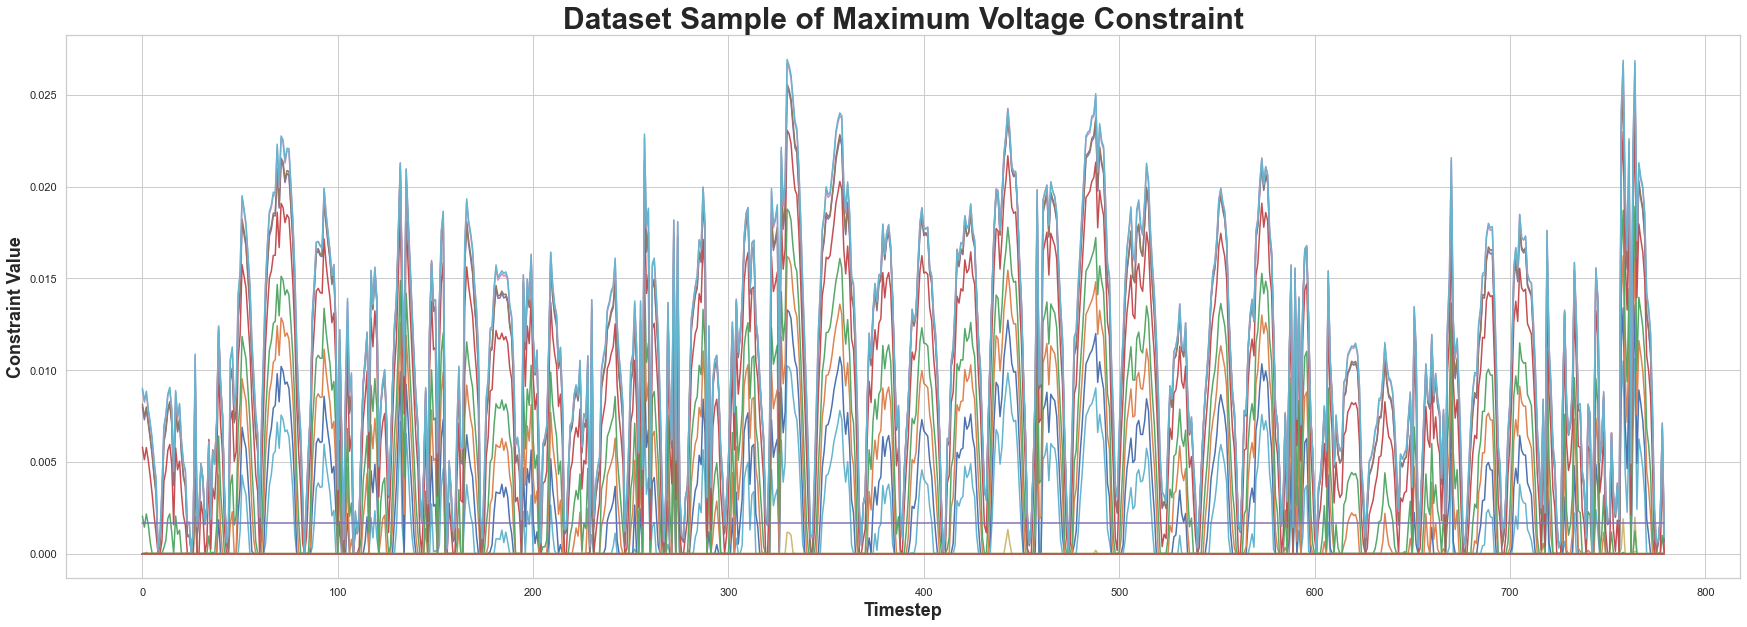

In [2]:
y_max_u_bal = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_bal_constr.csv')
exogenous_data_vm_pu_max_bal = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_bal.csv').drop(columns=['date'])
X_max_u_train, X_max_u_test, y_max_u_train, y_max_u_test = utils.split_and_suffle(exogenous_data_vm_pu_max_bal, y_max_u_bal)
data = {'X_train': X_max_u_train, 'X_test': X_max_u_test, 'y_train': y_max_u_train, 'y_test': y_max_u_test}
threshold_value = y_max_u_train.loc[:, y_max_u_train.max(axis=0) != 0].max(axis=0).mean() * 0.1 
threshold_signal = pd.Series(np.ones([len(y_max_u_test)]) * threshold_value)
# Plot prediction_gb_max_u
sns.set(style='whitegrid')
fig, axs = plt.subplots(1, 1, figsize=(30, 10))
axs.plot(y_max_u_test.reset_index(drop=True))
axs.plot(threshold_signal)
axs.set_title('Dataset Sample of Maximum Voltage Constraint', fontsize=30, fontweight='bold')
axs.set_xlabel('Timestep', fontsize=18, fontweight='bold')
axs.set_ylabel('Constraint Value', fontsize=18, fontweight='bold')
plt.show()

## Import Libraries

In [3]:
import optuna 
import os

import numpy as np
import pandas as pd 
import sklearn.metrics
from sklearn.model_selection import train_test_split

import sys
sys.path.append('..')
from thesis_package import aimodels as my_ai, utils, metrics

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters Tunning of Models
The objective of this section is to tune the hyperparameters of the models to obtain the best performance on the sparse dataset. In order to perfom the hyperparameters tunning, we are going to use the optuna library presented in the `optuna_introduction.ipynb` notebook. The models are the ones implemented in the `aimodel.py` file in the `thesis_package`.

In [4]:
# General parameters
num_trials = 100

### Extreme Gradient Boosting Regressor

In [5]:
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_bal_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_bal.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_max_u)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = train_y.loc[:, train_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.true_positives_rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-22 15:58:43,934] A new study created in memory with name: no-name-67d8154a-487a-43b3-a7ea-4e234244fca5
[I 2022-08-22 15:58:51,699] Trial 0 finished with value: 0.006228223831591397 and parameters: {'booster': 'gblinear', 'lambda': 0.04200532872094076, 'alpha': 1.5412906038580862e-08, 'subsample': 0.9428660367374833, 'colsample_bytree': 0.4081235934201445}. Best is trial 0 with value: 0.006228223831591397.
[I 2022-08-22 15:59:01,438] Trial 1 finished with value: 0.00563349372863209 and parameters: {'booster': 'gbtree', 'lambda': 1.8253369929039543e-07, 'alpha': 0.031643062920906684, 'subsample': 0.3538888459829764, 'colsample_bytree': 0.40312233625042393, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.10492708298181905, 'gamma': 6.338630028451804e-05, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 0.00563349372863209.
[I 2022-08-22 15:59:19,385] Trial 2 finished with value: 0.4898086625494125 and parameters: {'booster': 'gbtree', 'lambda': 0.00011335678572176242, '

Number of finished trials:  100
Best trial:
  Value: 0.004746721767657069
  Params: 
    booster: gbtree
    lambda: 4.288055780512365e-06
    alpha: 7.5629056802818344e-06
    subsample: 0.923150683853891
    colsample_bytree: 0.29590462079459834
    max_depth: 9
    min_child_weight: 7
    eta: 0.04974261878678785
    gamma: 2.4006274373913765e-06
    grow_policy: lossguide


In [6]:
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_bal_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_bal.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_min_u)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    model = my_ai.Context(my_ai.XGBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = train_y.loc[:, train_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.true_positives_rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_xgboost_regression_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-22 16:23:18,051] A new study created in memory with name: no-name-fbc6a7da-6234-4d6c-a105-761178d533b5
[I 2022-08-22 16:24:41,133] Trial 0 finished with value: 0.4922113133478822 and parameters: {'booster': 'dart', 'lambda': 0.008426680836243948, 'alpha': 0.00804718746767031, 'subsample': 0.9117262799368608, 'colsample_bytree': 0.3552880236571591, 'max_depth': 5, 'min_child_weight': 10, 'eta': 4.168583937223835e-08, 'gamma': 0.00027618231599345534, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 3.573834500438308e-07, 'skip_drop': 0.14507467311107253}. Best is trial 0 with value: 0.4922113133478822.
[I 2022-08-22 16:24:53,240] Trial 1 finished with value: 0.0066227789234578885 and parameters: {'booster': 'gblinear', 'lambda': 0.00470929248605753, 'alpha': 0.0128784072488218, 'subsample': 0.22634820361138397, 'colsample_bytree': 0.64291357734568}. Best is trial 1 with value: 0.0066227789234578885.
[I 2022-08-22 16:25:14,664] Trial

Number of finished trials:  100
Best trial:
  Value: 0.0047686450341566855
  Params: 
    booster: gbtree
    lambda: 0.0022873748876265547
    alpha: 4.7080182859143866e-07
    subsample: 0.8208513399117434
    colsample_bytree: 0.3880421550437328
    max_depth: 7
    min_child_weight: 6
    eta: 0.04780943557478916
    gamma: 0.0032619783528789396
    grow_policy: depthwise


### Gradient Boosting Regressor

In [7]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_bal_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_bal.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_max_u)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = train_y.loc[:, train_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.true_positives_rmse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-22 17:30:19,001] A new study created in memory with name: no-name-1f0b5325-f6a4-4573-a207-e6cd40401898
[I 2022-08-22 17:30:32,613] Trial 0 finished with value: 0.005419897173807168 and parameters: {'n_estimators': 79, 'learning_rate': 0.6287574596939038, 'loss': 'squared_error'}. Best is trial 0 with value: 0.005419897173807168.
[I 2022-08-22 17:32:24,032] Trial 1 finished with value: 0.00565245428479194 and parameters: {'n_estimators': 869, 'learning_rate': 0.5155818635650287, 'loss': 'squared_error'}. Best is trial 0 with value: 0.005419897173807168.
[I 2022-08-22 17:32:42,326] Trial 2 finished with value: 0.005497152983155561 and parameters: {'n_estimators': 113, 'learning_rate': 0.5979993365883011, 'loss': 'squared_error'}. Best is trial 0 with value: 0.005419897173807168.
[I 2022-08-22 17:32:46,847] Trial 3 finished with value: 0.005159240236131299 and parameters: {'n_estimators': 14, 'learning_rate': 0.14489154884783748, 'loss': 'squared_error'}. Best is trial 3 with v

Number of finished trials:  100
Best trial:
  Value: 0.004506710347566452
  Params: 
    n_estimators: 25
    learning_rate: 0.2724645522088135
    loss: squared_error


In [8]:
# Same implementation as above, but for Gradient Boosting Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_bal_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_bal.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y = utils.split_and_suffle(exogenous_data, y_min_u)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000, log=True),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0, log=True) ,
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error'])
    }
    model = my_ai.Context(my_ai.GradientBoostRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=valid_y.columns)
    # evaluate the regression performance with my metrics
    threshold = train_y.loc[:, train_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.true_positives_rmse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_gradient_boost_regression_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-22 18:01:44,187] A new study created in memory with name: no-name-fc2d7fdf-fa03-46ef-91a2-bdc26db93044
[I 2022-08-22 18:02:14,759] Trial 0 finished with value: 0.0056634413659187545 and parameters: {'n_estimators': 83, 'learning_rate': 0.8543162999917417, 'loss': 'squared_error'}. Best is trial 0 with value: 0.0056634413659187545.
[I 2022-08-22 18:02:47,228] Trial 1 finished with value: 0.006173765896393653 and parameters: {'n_estimators': 77, 'learning_rate': 0.29970706948240994, 'loss': 'absolute_error'}. Best is trial 0 with value: 0.0056634413659187545.
[I 2022-08-22 18:06:08,677] Trial 2 finished with value: 0.005954975283162772 and parameters: {'n_estimators': 689, 'learning_rate': 0.24505223365897505, 'loss': 'squared_error'}. Best is trial 0 with value: 0.0056634413659187545.
[I 2022-08-22 18:06:37,795] Trial 3 finished with value: 0.006634188178843849 and parameters: {'n_estimators': 65, 'learning_rate': 0.2573923190914948, 'loss': 'absolute_error'}. Best is trial 0

Number of finished trials:  100
Best trial:
  Value: 0.00514602580023137
  Params: 
    n_estimators: 74
    learning_rate: 0.8511834961992796
    loss: squared_error


### Support Vector Regressor

In [9]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_max_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_bal_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_max_bal.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_max_u, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=y_max_u.columns)
    train_y = pd.DataFrame(train_y, columns=y_max_u.columns)
    # evaluate the regression performance with my metrics
    threshold = train_y.loc[:, train_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    valid_y = pd.DataFrame(valid_y, columns=y_max_u.columns)
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.true_positives_rmse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_focused_max_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-22 19:09:59,135] A new study created in memory with name: no-name-8c4052bb-a535-4a31-a96c-50d1a8a068e7
[I 2022-08-22 19:10:09,818] Trial 0 finished with value: 0.3279033695218681 and parameters: {'kernel': 'rbf', 'C': 6.752332744047289e-07, 'degree': 5, 'gamma': 4.1837474218246885e-05}. Best is trial 0 with value: 0.3279033695218681.
[I 2022-08-22 19:10:19,615] Trial 1 finished with value: 0.3177263203748711 and parameters: {'kernel': 'rbf', 'C': 0.6932852680148542, 'degree': 3, 'gamma': 0.0009736535157129803}. Best is trial 1 with value: 0.3177263203748711.
[I 2022-08-22 19:10:26,634] Trial 2 finished with value: 0.30356850283218634 and parameters: {'kernel': 'poly', 'C': 0.00795780249221081, 'degree': 2, 'gamma': 0.3964407516183931}. Best is trial 2 with value: 0.30356850283218634.
[I 2022-08-22 19:10:33,377] Trial 3 finished with value: 0.32598925736159007 and parameters: {'kernel': 'poly', 'C': 2.6807112094291856e-06, 'degree': 4, 'gamma': 0.0010226914483036744}. Best is

Number of finished trials:  100
Best trial:
  Value: 0.2999199774846511
  Params: 
    kernel: poly
    C: 0.005584880493571942
    degree: 2
    gamma: 0.8532257247043119


In [10]:
# Same implementation as above, but for Support Vector Regression.
def objective(trial):
    # import data
    y_min_u = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_min_bal_constr.csv')
    exogenous_data = pd.read_csv('..\data\ground_truth\\exogenous_data_vm_pu_min_bal.csv').drop(columns=['date'])
    train_x, valid_x, train_y, valid_y, scaler = utils.split_and_suffle(exogenous_data, y_min_u, scaling=True)
    data = {'X_train': train_x, 'X_test': valid_x, 'y_train': train_y, 'y_test': valid_y}
    param = {
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf']),
        'C': trial.suggest_float('C', 1e-8, 1.0, log=True),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True)
    }
    model = my_ai.Context(my_ai.SupportVectorRegressorStrategy(param))
    model.fit(data)
    prediction = model.predict(data)
    prediction = pd.DataFrame(prediction , columns=y_min_u.columns)
    train_y = pd.DataFrame(train_y, columns=y_min_u.columns)
    # evaluate the regression performance with my metrics
    threshold = train_y.loc[:, train_y.max(axis=0) != 0].max(axis=0).mean() * 0.1 
    metric = metrics.Metrics()
    valid_y = pd.DataFrame(valid_y, columns=y_min_u.columns)
    metric.get_prediction_scores(prediction, valid_y, threshold=threshold)
    return metric.true_positives_rmse
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=num_trials)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Write the results to a csv file.
with open("./hyper_params_results/params_support_vector_regression_focused_min_u.csv", "w") as f:
    f.write("params,value\n")
    for key, value in trial.params.items():
        f.write("{},{}\n".format(key, value))
    f.write("value,{}\n".format(trial.value))

[I 2022-08-22 20:30:21,832] A new study created in memory with name: no-name-0ea95ce6-b591-4cc9-9d37-23578bcfc82c
[I 2022-08-22 20:30:42,335] Trial 0 finished with value: 0.27782753328302495 and parameters: {'kernel': 'poly', 'C': 4.119979595152977e-06, 'degree': 4, 'gamma': 6.7305014313566246e-06}. Best is trial 0 with value: 0.27782753328302495.
[I 2022-08-22 20:31:14,033] Trial 1 finished with value: 0.27777329649331406 and parameters: {'kernel': 'rbf', 'C': 8.264309132063999e-08, 'degree': 4, 'gamma': 0.00031830124914893423}. Best is trial 1 with value: 0.27777329649331406.
[I 2022-08-22 20:31:33,260] Trial 2 finished with value: 0.2777732877160443 and parameters: {'kernel': 'poly', 'C': 0.00034359829670068147, 'degree': 1, 'gamma': 6.629959297273157e-07}. Best is trial 2 with value: 0.2777732877160443.
[I 2022-08-22 20:32:09,715] Trial 3 finished with value: 0.2778169725792317 and parameters: {'kernel': 'rbf', 'C': 0.04567765770977339, 'degree': 1, 'gamma': 1.7418897607024907e-07}

Number of finished trials:  100
Best trial:
  Value: 0.19794213653821938
  Params: 
    kernel: rbf
    C: 0.23459004141044545
    degree: 5
    gamma: 0.9827535390703468
